In [112]:

import numpy as np
import pandas as pd
#Encodeurs
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler, PolynomialFeatures
#Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
#Estimateurs
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

import mlflow
from utils import mlflow_it

In [113]:
data = pd.read_csv('data/bronze.csv')

In [114]:
X = data.drop(['MEDV'], axis=1)
y = data.MEDV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [115]:
numerical_features = X.select_dtypes(include=['int','float']).columns

In [116]:
categorical_features = X.select_dtypes(include=['bool']).columns

In [117]:
std = StandardScaler()
minmax = MinMaxScaler()
rbst = RobustScaler()

scalers = [std, minmax, rbst]


In [118]:
lnr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
gbr = GradientBoostingRegressor()

In [119]:
scaler = rbst

estimator = GradientBoostingRegressor(
    subsample = 0.8,
    n_estimators=500,
    min_samples_split=5,
    min_samples_leaf=2,
    max_depth=3,
    learning_rate=0.09000000000000001
    )

In [120]:
preprocessor = make_column_transformer(
    (OneHotEncoder(sparse_output=True), categorical_features),
    (scaler, numerical_features),
    (PolynomialFeatures(degree=3, include_bias=False), numerical_features),
    remainder='passthrough'
)

In [121]:
pipeline = make_pipeline(
    preprocessor,
    estimator
)

In [122]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  Index(['CHAS'], dtype='object')),
                                                 ('robustscaler',
                                                  RobustScaler(),
                                                  Index(['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  Index(['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object'))])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.09000000000000001,
                                           min_samples_leaf=2,
                                           min_samples_split=5,
                                           n_estimators=500, subsample=0.8))])

In [123]:
score = pipeline.score(X_test, y_test)
score


0.9256085564827901

In [124]:
mlflow_it(pipeline, X_train, y_train, X_test, y_test)

2023/06/13 00:35:29 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.4.1, required: mlflow==2.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2023/06/13 00:35:29 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/06/13 00:35:29 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer None requires all feature values to be numeric, and each feature column must only contain scalar values.


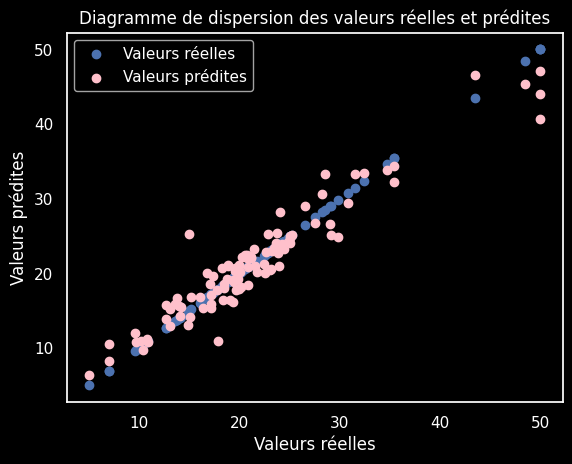

In [125]:
import matplotlib.pyplot as plt

# Calcul des valeurs prédites
y_pred = pipeline.predict(X_test)

# Diagramme de dispersion avec valeurs réelles en bleu
plt.scatter(y_test, y_test, c='b', label='Valeurs réelles')

# Diagramme de dispersion avec valeurs prédites en rose
plt.scatter(y_test, y_pred, c='pink', label='Valeurs prédites')

plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Diagramme de dispersion des valeurs réelles et prédites')
plt.legend()
plt.show()


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/apprenant/miniconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/apprenant/miniconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/home/apprenant/miniconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/apprenant/miniconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/apprenant/miniconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/pipeline.py", line 480, in predict
    Xt = transform.transform(Xt)
  File "/h

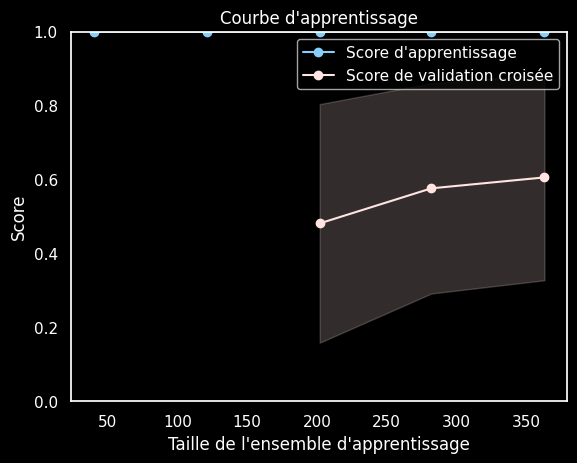

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Calcul de la courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X, y,
    train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9],
    cv=5,
    scoring='r2'
)

# Calcul des scores moyens et écart-types
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Tracé de la courbe d'apprentissage
plt.figure()
plt.title('Courbe d\'apprentissage')
plt.xlabel('Taille de l\'ensemble d\'apprentissage')
plt.ylabel('Score')
plt.ylim(0.0, 1.0)

# Tracé des scores d'apprentissage
plt.plot(train_sizes, train_scores_mean, 'o-', color='lightskyblue', label='Score d\'apprentissage')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='lightskyblue')

# Tracé des scores de validation croisée
plt.plot(train_sizes, test_scores_mean, 'o-', color='mistyrose', label='Score de validation croisée')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='mistyrose')

plt.legend()
plt.show()


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/apprenant/miniconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/apprenant/miniconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/home/apprenant/miniconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/apprenant/miniconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/apprenant/miniconda3/envs/pycaret/lib/python3.8/site-packages/sklearn/pipeline.py", line 480, in predict
    Xt = transform.transform(Xt)
  File "/h

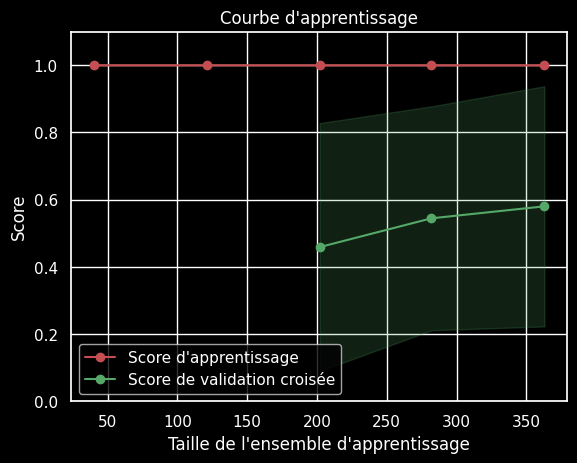

In [127]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
# Afficher la matrice de corrélation avec une heatmap
sns.set()
plt.style.use("dark_background")

# Calcul de la courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X, y,
    train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9],  # Proportions de l'ensemble d'apprentissage à utiliser
    cv=5,  # Nombre de folds pour la validation croisée
    scoring='r2'  # Métrique à utiliser (utilisez la même métrique que celle que vous utilisez pour évaluer votre modèle)
)

# Calcul des scores moyens et écart-types
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Tracé de la courbe d'apprentissage
plt.figure()
plt.title('Courbe d\'apprentissage')
plt.xlabel('Taille de l\'ensemble d\'apprentissage')
plt.ylabel('Score')
plt.ylim(0.0, 1.1)

# Tracé de la courbe de score d'apprentissage
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Score d\'apprentissage')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='r')

# Tracé de la courbe de score de validation croisée
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Score de validation croisée')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='g')

plt.legend(loc='best')
plt.grid(True)
plt.show()


In [128]:
import shap

# Extraction du modèle final du pipeline
model = pipeline.named_steps['gradientboostingregressor']

# Calcul des valeurs SHAP
explainer = shap.Explainer(model, feature_perturbation='interventional')
shap_values = explainer.shap_values(X_test)

# Tracé de la visualisation SHAP
shap.summary_plot(shap_values, X_test, plot_type="dot", color=['lightskyblue', 'mistyrose'])


: 

: 